# Deconvolution Analysis (DANA)

In [148]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [149]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import time_

In [150]:
from dataclasses import dataclass

In [151]:
import invisible_cities.core.system_of_units  as units
from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.io.dst_io    import load_dst
from invisible_cities.core.core_functions import in_range

In [152]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [153]:
from nextflex.core import Setup
from nextflex.core import KEY_sensor_fibres 
from nextflex.core import KEY_sensor_pmts   
from nextflex.core import S1_time           
from nextflex.core import SIPM_ids
from nextflex.core import get_sipm_postions
from nextflex.core import get_sensor_response

In [154]:
from nextflex.graphics_reco   import plot_hits3d

In [155]:
from  tics.stats_tics import bin_data_with_equal_bin_size
from tics.pd_tics   import get_index_slice_from_multi_index
from tics.util_tics   import find_nearest

In [156]:
from nextflex.types import EventHits

In [371]:
from nextflex.types import  ResponseSiPM
from nextflex.reco_functions import get_sipm_response
from nextflex.reco_functions import get_sipm_positions
from nextflex.reco_functions import get_event_sipm
from nextflex.reco_functions import get_sipm_event_hits
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxel_distances

In [201]:
from nextflex.graphics_reco   import plot_hits3d
from nextflex.graphics_reco   import plot_hits_projections
from nextflex.graphics_reco   import plot_hits_xy
from nextflex.graphics_reco   import bin_hits
from nextflex.graphics_reco   import bin_hits_xy
from nextflex.analysis_graphics import plot_multiple_tracks

In [159]:
from nextflex.tracks_dst import event_reco_hits

In [160]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [181]:
from nextflex.reco_functions import voxelize_hits

In [162]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from skimage.measure import label, regionprops
from skimage import data, util
from skimage.measure import label
from skimage.measure._regionprops import RegionProperties

In [163]:
from nextflex.reco_image_functions import label_slice
from nextflex.reco_image_functions import select_slice_by_label
from nextflex.reco_image_functions import image_from_df
from nextflex.reco_image_functions import detector_grid
from nextflex.reco_image_functions import Point
from nextflex.reco_image_functions import get_psf
from nextflex.reco_image_functions import print_region_properties

In [164]:
from invisible_cities. reco.deconv_functions import deconvolution_input
from invisible_cities. reco.deconv_functions import richardson_lucy
from invisible_cities. reco.deconv_functions import deconvolve
from invisible_cities.cities.beersheba         import DeconvolutionMode
from invisible_cities.  reco.deconv_functions  import InterpolationMethod
from invisible_cities.cities.beersheba         import CutType
from invisible_cities.core.core_functions import shift_to_bin_centers

In [165]:
from nextflex.deconvolution import lr_deconvolution

## Code

In [166]:
def rebin_time(df : pd.DataFrame)->pd.Series:
        """
        takes the mean time and the energy sum

        """
        d = {}
        d['time'] = df['time'][0]
        d['charge'] = df['charge'].sum()
        return pd.Series(d)


## Setup

In [167]:
FDATA = os.environ['FLEXDATA']
testDir  = os.path.join(FDATA,"testSetupData")
print(f"test dir = {testDir}")

test dir = /Users/jj/Development/flexdata/testSetupData


In [168]:
setbb = Setup(flexDATA = testDir,
              tpConfig = "FLEX100_M6_O6.EL8bar.bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6.EL8bar.bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar.bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu
        analysis directory           = /Users/jj/Development/flexdata/testSetupData/analysis/FLEX100_M6_O6.EL8bar.bb0nu
        number of h5 files in dir    = 1
        sipm map at                  = /Users/jj/Development/flexdata/testSetupData/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/testSetupData/kdsts/FLEX100_M6_O

In [169]:
setbb.ifnames[0]

'/Users/jj/Development/flexdata/testSetupData/FLEX100_M6_O6.EL8bar.bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5'

In [170]:
setbb.pitch

15.55

In [171]:
setbb.mc_config()

,param_value
param_key,
num_events,4
TP_SiPM_binning,1.000000 mus
/Geometry/NextFlex/e_lifetime,1000. ms
/Geometry/NextFlex/el_gap_length,10. mm
/Geometry/NextFlex/el_field_int,16. kilovolt/cm
/Geometry/NextFlex/tp_teflon_thickness,6. mm
/Geometry/NextFlex/tp_teflon_hole_diam,6. mm
/Geometry/NextFlex/tp_sipm_sizeX,1.3 mm
/Geometry/NextFlex/tp_sipm_pitchX,15.55 mm


## Compute EventHits

In [175]:
ifname = setbb.ifnames[0]

### Pre-selection

In [548]:
ecut       = 10     # minimum energy 5 pes
bin_size   = 20    # vox size 20 mm (larger than pitch)
contiguity = 35    # > 2 x pitch

In [549]:
evt= 0

In [550]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 0, event id = 212 nof gtracks = 3


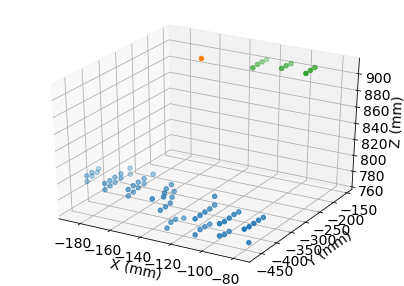

In [551]:
plot_multiple_tracks(GTRKS, figsize = (7,5), fontsize=10)

In [553]:
voxdfs = [GTRKS[i].voxels_df for i in range(0, len(GTRKS))]
voxdfs

[             x           y           z  energy  nhits
 0  -186.600006 -435.399994  793.565217    46.0    4.0
 1  -186.600006 -435.399994  800.446809    47.0    4.0
 2  -186.600006 -419.850006  796.609375    64.0    4.0
 3  -186.600006 -419.850006  801.027027   111.0    5.0
 4  -186.600006 -404.299988  797.290909    55.0    3.0
 ..         ...         ...         ...     ...    ...
 58  -77.750000 -450.950012  767.000000    12.0    1.0
 59  -77.750000 -450.950012  786.568182    88.0    6.0
 60  -77.750000 -435.399994  786.539394   165.0    8.0
 61  -77.750000 -419.850006  786.566265    83.0    6.0
 62  -77.750000 -404.299988  786.000000    11.0    1.0
 
 [63 rows x 5 columns],
        x           y      z  energy  nhits
 0 -155.5 -217.699997  908.0    12.0    1.0,
             x           y           z  energy  nhits
 0  -93.300003 -155.500000  904.380282    71.0    4.0
 1  -93.300003 -171.050003  904.057143   175.0    7.0
 2 -124.400002 -155.500000  903.439252   107.0    6.0
 3 -124.4

In [554]:
evt = 1

In [555]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 1, event id = 213 nof gtracks = 1


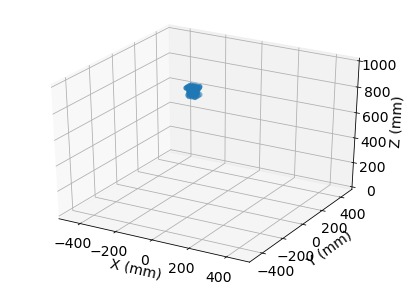

In [557]:
plot_multiple_tracks(GTRKS, autorange=False, figsize = (7,5), fontsize=10)

In [558]:
voxdfs = [GTRKS[i].voxels_df for i in range(0, len(GTRKS))]
voxdfs

[             x           y           z  energy  nhits
 0  -264.350006  248.800003  710.000000    40.0    3.0
 1  -264.350006  264.350006  646.434783    23.0    2.0
 2  -264.350006  264.350006  701.669903   103.0    6.0
 3  -264.350006  264.350006  711.731092   238.0   12.0
 4  -264.350006  279.899994  649.000000    11.0    1.0
 ..         ...         ...         ...     ...    ...
 58 -217.021451  279.899994  698.563636   275.0   14.0
 59 -216.743774  279.899994  711.269400   683.0   16.0
 60 -214.946755  295.450012  648.837905   401.0   15.0
 61 -217.699997  295.450012  702.086957    92.0    5.0
 62 -216.385107  297.508099  710.897059   272.0   13.0
 
 [63 rows x 5 columns]]

In [559]:
evt = 2

In [560]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 2, event id = 214 nof gtracks = 1


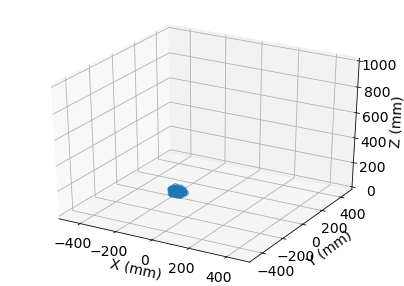

In [562]:
plot_multiple_tracks(GTRKS, autorange=False, figsize = (7,5), fontsize=10)

In [563]:
voxdfs = [GTRKS[i].voxels_df for i in range(0, len(GTRKS))]
voxdfs

[             x          y           z  energy  nhits
 0  -155.500000 -93.300003   65.000000    14.0    1.0
 1  -155.500000 -93.300003   91.000000    11.0    1.0
 2  -155.500000 -93.300003  103.771084    83.0    5.0
 3  -155.500000 -77.750000   64.117647    51.0    4.0
 4  -155.500000 -77.750000   88.571429    35.0    2.0
 ..         ...        ...         ...     ...    ...
 60  -93.300003 -77.750000   92.694444    72.0    3.0
 61  -93.300003 -62.200001   63.956522    23.0    2.0
 62  -92.390162 -62.200001   80.212766   188.0   12.0
 63  -93.300003 -62.200001   92.000000    12.0    1.0
 64  -93.300003 -46.650002   65.440000    25.0    2.0
 
 [65 rows x 5 columns]]

In [564]:
evt = 3

In [565]:
sipm_evt      = get_event_sipm(sipm_response, sipm_evts[evt])
sipm_hits = get_sipm_event_hits(sipm_evt, sipm_positions, ecut)
voxHits = voxelize_hits(sipm_hits, bin_size)
gtracks  = make_track_graphs(voxHits, contiguity)
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=contiguity)\
                             for gtr in gtracks]
print(f" event in list {evt}, event id = {sipm_hits.event_id} nof gtracks = {len(gtracks)}")

 event in list 3, event id = 215 nof gtracks = 1


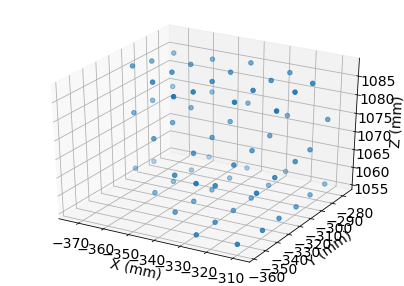

In [566]:
plot_multiple_tracks(GTRKS, figsize = (7,5), fontsize=10)

##### Energy cut at 10 pes OK

## Deconvolution

### Raw track

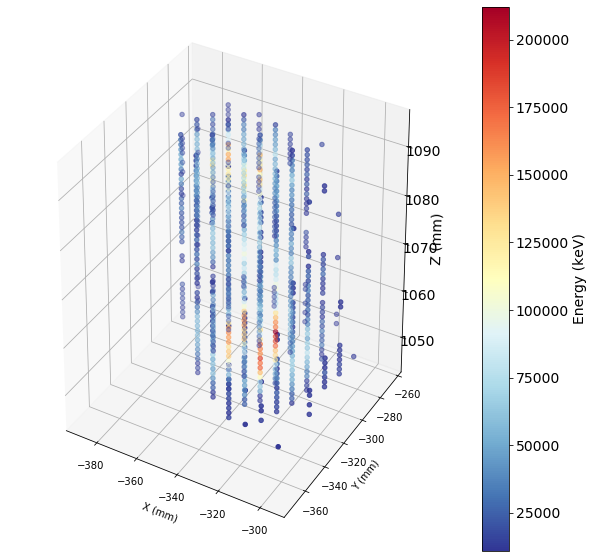

In [567]:
plot_hits3d(sipm_hits,
                autorange = True,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [568]:
binHits = bin_hits(sipm_hits)

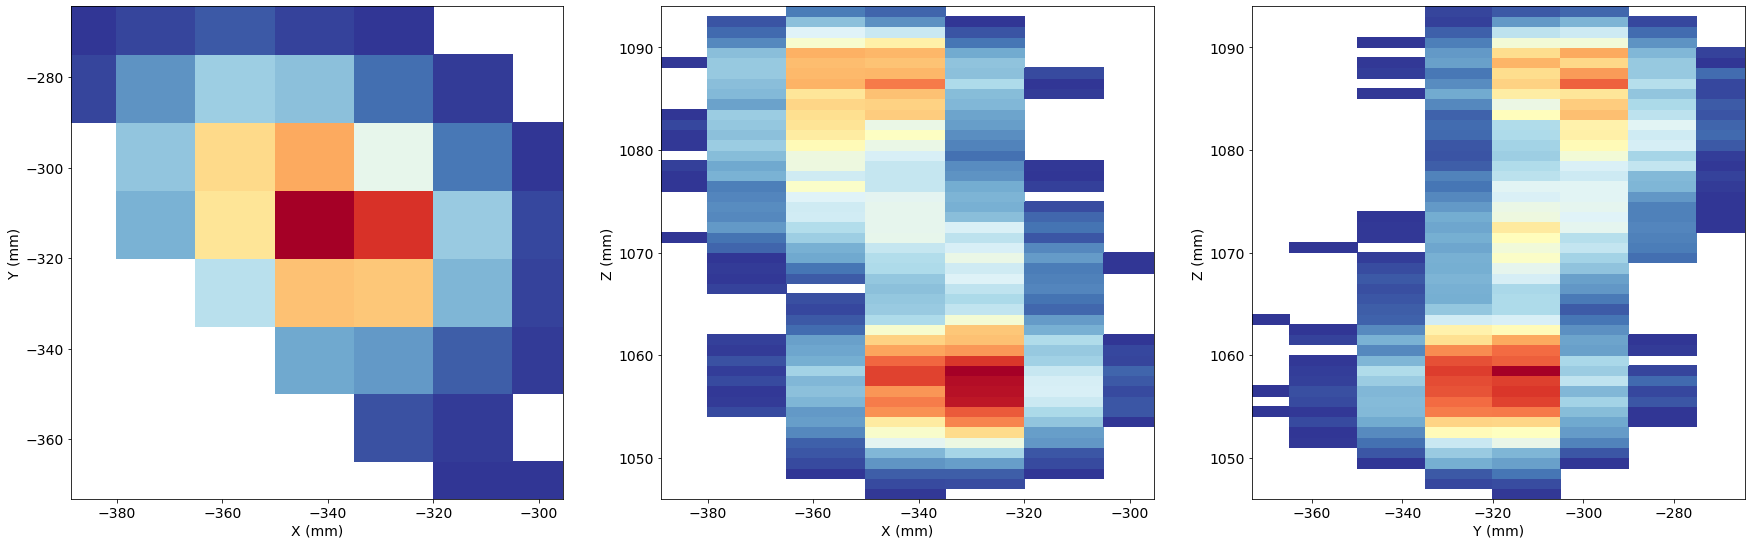

In [569]:
plot_hits_projections(sipm_hits, binHits,  masked=True, figsize=(30, 10))

### Prepare data

#### Deconvolution parameters

In [570]:
bin_size      = (3., 3.)
sample_width  = (15.5, 15.5)
inter_method    = InterpolationMethod.cubic

#### Total and max energy

In [571]:
etot = sipm_hits.df.energy.sum()
emax = sipm_hits.df.energy.max()
print(f" Total energy = {etot}, max energy = {emax}")

 Total energy = 33511, max energy = 212


#### Slicing in z 

In [572]:
zsl = np.unique(sipm_hits.df.z.values)
print(f"number of z slices = {len(zsl)}")

number of z slices = 49


In [573]:
len_slices = [len(sipm_hits.df[sipm_hits.df.z == zs]) for zs in zsl]

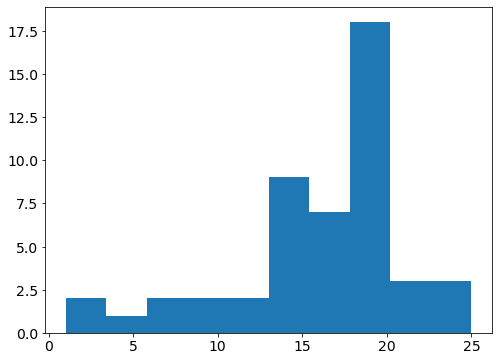

In [574]:
_ = plt.hist(len_slices)

In [575]:
lmax = np.max(len_slices)
ilmax = np.argmax(len_slices)
print(f" length of slice (max) ={lmax}, i = {ilmax}")

 length of slice (max) =25, i = 11


### Deconvolve longer slice

In [576]:
dfzm = sipm_hits.df[sipm_hits.df.z == zsl[ilmax]].reset_index(drop=True)

In [577]:
dfzm.head()

,x,y,z,energy
0,-326.549988,-357.649994,1057.0,20
1,-342.100006,-342.100006,1057.0,53
2,-326.549988,-342.100006,1057.0,61
3,-311.000000,-342.100006,1057.0,24
4,-295.450012,-342.100006,1057.0,13


In [578]:
print(f"""
Larger slice in z at position = {zsl[ilmax]}
numper of hits                = {len(dfzm)}
max energy =                  = {dfzm.energy.max()}
        """)


Larger slice in z at position = 1057.0
numper of hits                = 25
max energy =                  = 184
        


In [579]:
dfzn = dfzm.copy()

In [580]:
dfzn['energy'] = dfzn.energy / emax

In [581]:
dfzn.energy.max()

0.8679245283018868

In [582]:
dfzn.head()

,x,y,z,energy
0,-326.549988,-357.649994,1057.0,0.094340
1,-342.100006,-342.100006,1057.0,0.250000
2,-326.549988,-342.100006,1057.0,0.287736
3,-311.000000,-342.100006,1057.0,0.113208
4,-295.450012,-342.100006,1057.0,0.061321


In [583]:
binHits = bin_hits_xy(dfzn)

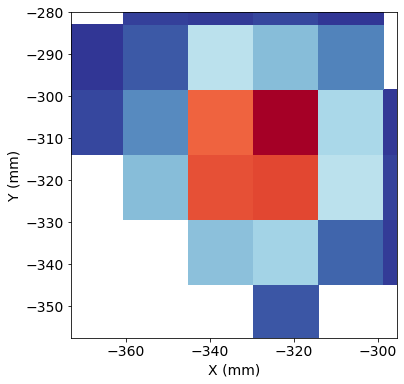

In [584]:
plot_hits_xy(dfzn, binHits,  masked=True, figsize=(6, 6))

##### Notice isolated clusters (cut at 5 pes is low)

#### Labelling a slice in z and selecting by label

In [585]:
sckl = label_slice(dfzn)

##### Label matrix shows 5 regions, only one has a cluster of SiPMs all the others are isolated SiPMs

In [586]:
sckl.lbl

array([[0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 0]])

In [587]:
len(sckl.prp)

1

##### Properties has 3 regions (corresponding to labeling)

In [588]:
print_region_properties(sckl.prp)

 number of regions = 1

        region      = 0
        label       = 1
        area        = 25
        coordinates = [[0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [2 5]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [5 1]
 [5 2]
 [5 3]]
        intensiy    = [[0.         0.         0.         0.0754717  0.05188679 0.        ]
 [0.         0.         0.24528302 0.16509434 0.0990566  0.06603774]
 [0.         0.25       0.74056604 0.71698113 0.32075472 0.06132075]
 [0.09433962 0.28773585 0.75471698 0.86792453 0.24528302 0.0754717 ]
 [0.         0.11320755 0.32075472 0.29716981 0.15566038 0.05188679]
 [0.         0.06132075 0.07075472 0.05660377 0.         0.        ]]
        


##### In the selection by size we require a size of at least 2 (no isolated SiPMs)

In [589]:
dfzs = select_slice_by_label(dfzn, sckl, min_size=2)

In [590]:
dfzs.head()

,x,y,energy
0,-373.200012,-311.000000,0.075472
1,-373.200012,-295.450012,0.051887
2,-357.649994,-326.549988,0.245283
3,-357.649994,-311.000000,0.165094
4,-357.649994,-295.450012,0.099057


In [591]:
print(f""" 
selection in z:
xmin = {dfzs.x.min()}
xmax = {dfzs.x.max()}
ymin = {dfzs.y.min()}
ymax = {dfzs.y.max()}

""")

 
selection in z:
xmin = -373.20001220703125
xmax = -295.45001220703125
ymin = -357.6499938964844
ymax = -279.8999938964844




In [592]:
xx = dfzs.x.mean()
yy = dfzs.y.mean()
zz = dfzn.z.values[0]
print(f"xmean = {xx}, ymean={yy} zmean = {zz}")

xmean = -334.0140014648438, ymean=-319.70799926757815 zmean = 1057.0


#### Prepare detector grid

In [593]:
det_grid = detector_grid(dfzs, bin_size)

In [594]:
izn = image_from_df(dfzs, det_grid, sample_width)

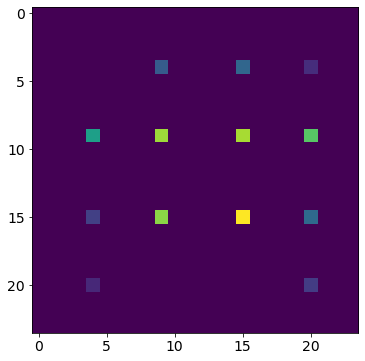

In [595]:
plt.imshow(izn.T)

#### Interpolation 

In [596]:
interpolator = deconvolution_input(sample_width, 
                                   det_grid, 
                                   inter_method)

In [597]:
inter_values, inter_pos = interpolator((dfzs.x.values, dfzs.y.values), dfzs.energy.values)

In [598]:
len(inter_values.flatten())

625

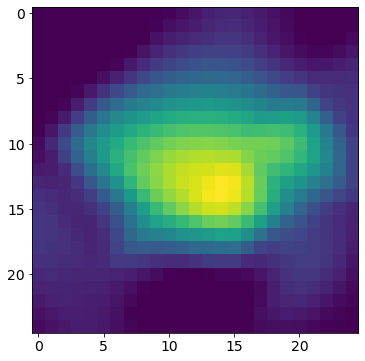

In [599]:
plt.imshow(inter_values.T)

In [600]:
dfzi = pd.DataFrame({'x' : inter_pos[0].flatten(), 
                     'y' : inter_pos[1].flatten(), 
                     'energy' : inter_values.flatten() })

In [601]:
dfzi

,x,y,energy
0,-371.700012,-356.149994,0.000479
1,-371.700012,-353.149994,0.001257
2,-371.700012,-350.149994,0.001759
3,-371.700012,-347.149994,0.001171
4,-371.700012,-344.149994,0.000000
...,...,...,...
620,-299.700012,-296.149994,0.044591
621,-299.700012,-293.149994,0.022925
622,-299.700012,-290.149994,0.011704
623,-299.700012,-287.149994,0.006620


In [602]:
binHits = bin_hits_xy(dfzi,
            xr = (dfzi.x.min(), dfzi.x.max()),
            yr = (dfzi.y.min(), dfzi.y.max()),
            pitch = (1, 1))

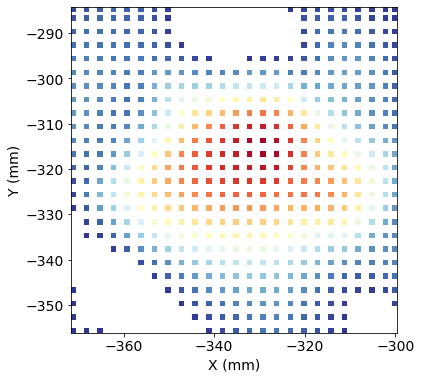

In [603]:
plot_hits_xy(dfzi, binHits,  masked=True, figsize=(6, 6))

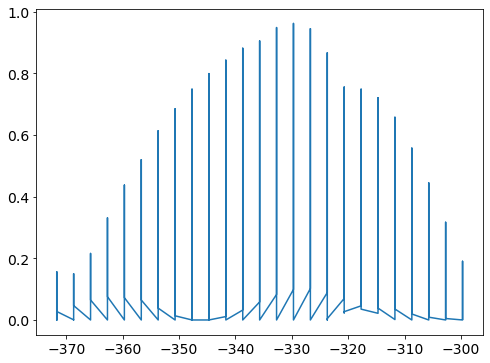

In [604]:
plt.plot(dfzi.x, dfzi.energy)

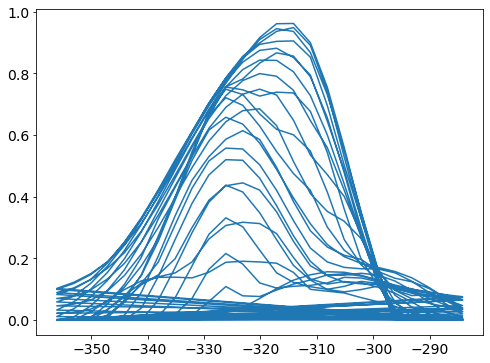

In [605]:
plt.plot(dfzi.y, dfzi.energy)

#### PSF

In [606]:
pspath = os.path.join(FDATA, "PSFs")
psfname1 = "PSF_flex_EL_diff.h5"
psfname2 = "PSF_flex_EL_diff_3mm.h5"

In [607]:
xyz = Point(xx,yy,zz)

In [608]:
psf_deco = get_psf(pspath, psfname2, dfzs, xyz)

In [609]:
psf_deco.shape

(66, 66)

#### RL deconvolution

In [610]:
start_time = time.perf_counter() 
deconv_image  = np.nan_to_num(richardson_lucy(inter_values, psf_deco, 90, 1e-10))
                                                     
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

LR from IC run in 0.07257393302279525 seconds


In [611]:
deconv_image.T.shape

(25, 25)

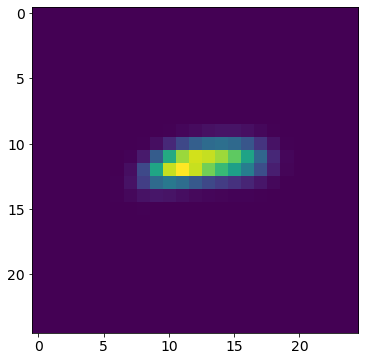

In [612]:
plt.imshow(deconv_image.T)

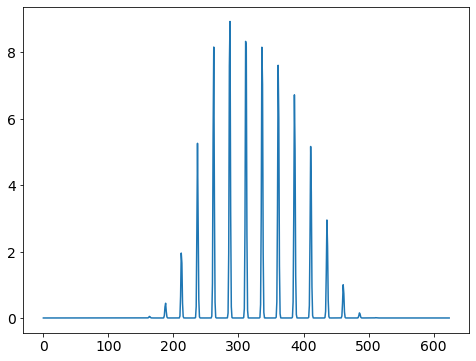

In [613]:
plt.plot(deconv_image.flatten())

In [614]:
dcdf = pd.DataFrame({"x" : inter_pos[0],
                     "y" : inter_pos[1],
                    "energy" : deconv_image.flatten()})

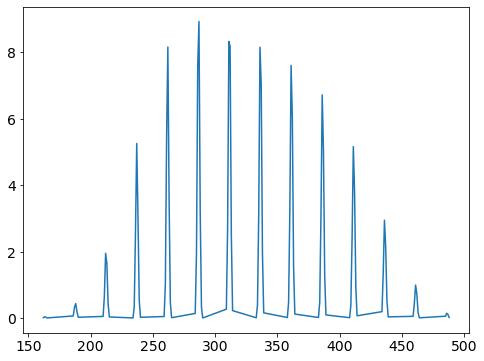

In [615]:
plt.plot(dcdf.energy[dcdf.energy>0.01])

In [616]:
dcdfs = dcdf[dcdf.energy>1]

In [617]:
binHits = bin_hits_xy(dcdfs,
            xr = (dcdfs.x.min(), dcdfs.x.max()),
            yr = (dcdfs.y.min(), dcdfs.y.max()),
            pitch = (1, 1))

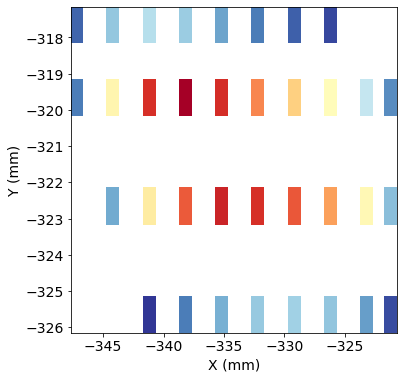

In [618]:
plot_hits_xy(dcdfs, binHits,  masked=True, figsize=(6, 6))

### Deconvolution all slices

In [619]:
pspath = os.path.join(FDATA, "PSFs")
psfname = "PSF_flex_EL_diff.h5"
psfname2 = "PSF_flex_EL_diff_3mm.h5"

In [647]:
start_time = time.perf_counter() 
dcHits = lr_deconvolution(sipm_hits,
                          pspath,
                          psfname2,
                         bin_size     = (3., 3.),
                         sample_width = (15.5, 15.5),
                         inter_method = InterpolationMethod.cubic,
                         n_iter       = 90,
                         e_min        = 0.1,
                         interactive  = 0)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'LR from IC run in {run_time} seconds')

warning min_hits < = 2: skipping
warning min_hits < = 2: skipping
LR from IC run in 6.131945344997803 seconds


In [648]:
dcHits

<EventHits>
        event number = 215
        event type   = None
        topology     = None
        Columns = ('x', 'y', 'z', 'energy')
        

In [649]:
dcHits.df

,x,y,z,energy
0,-334.600006,-319.049988,1047.0,0.592186
1,-334.600006,-316.049988,1047.0,0.519262
2,-331.600006,-319.049988,1047.0,0.499678
3,-331.600006,-316.049988,1047.0,0.446260
4,-344.149994,-319.049988,1048.0,1.097629
...,...,...,...,...
1590,-350.149994,-313.049988,1093.0,0.205669
1591,-350.149994,-310.049988,1093.0,1.920970
1592,-350.149994,-307.049988,1093.0,1.387963
1593,-347.149994,-310.049988,1093.0,0.853331


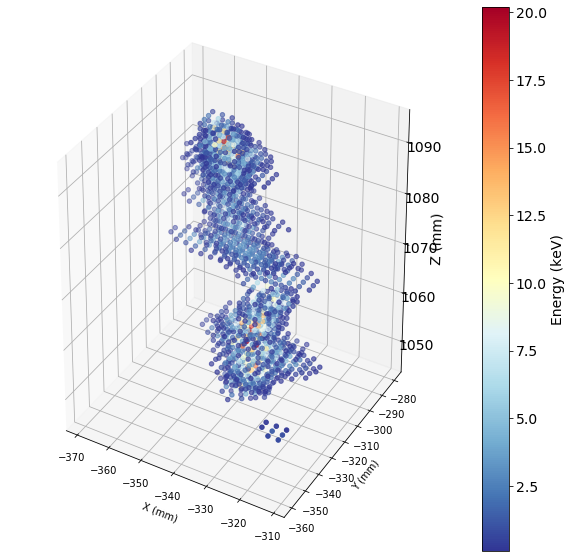

In [650]:
plot_hits3d(dcHits,
                autorange = True,
                energyKeV = False,
                xrange    = (-500,500),
                yrange    = (-500,500),
                zrange    = (0,1000),
                figsize   = (10,10),
                fontsize  = 10)

In [651]:
len(dcHits.df)

1595

In [652]:
dcHits2 =dcHits.df[dcHits.df.energy>0.2]

(array([770., 262., 160., 113.,  59.,  58.,  39.,  34.,  36.,  16.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

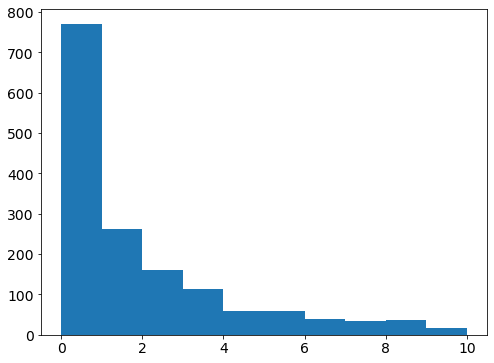

In [653]:
plt.hist(dcHits.df.energy, range=(0,10))

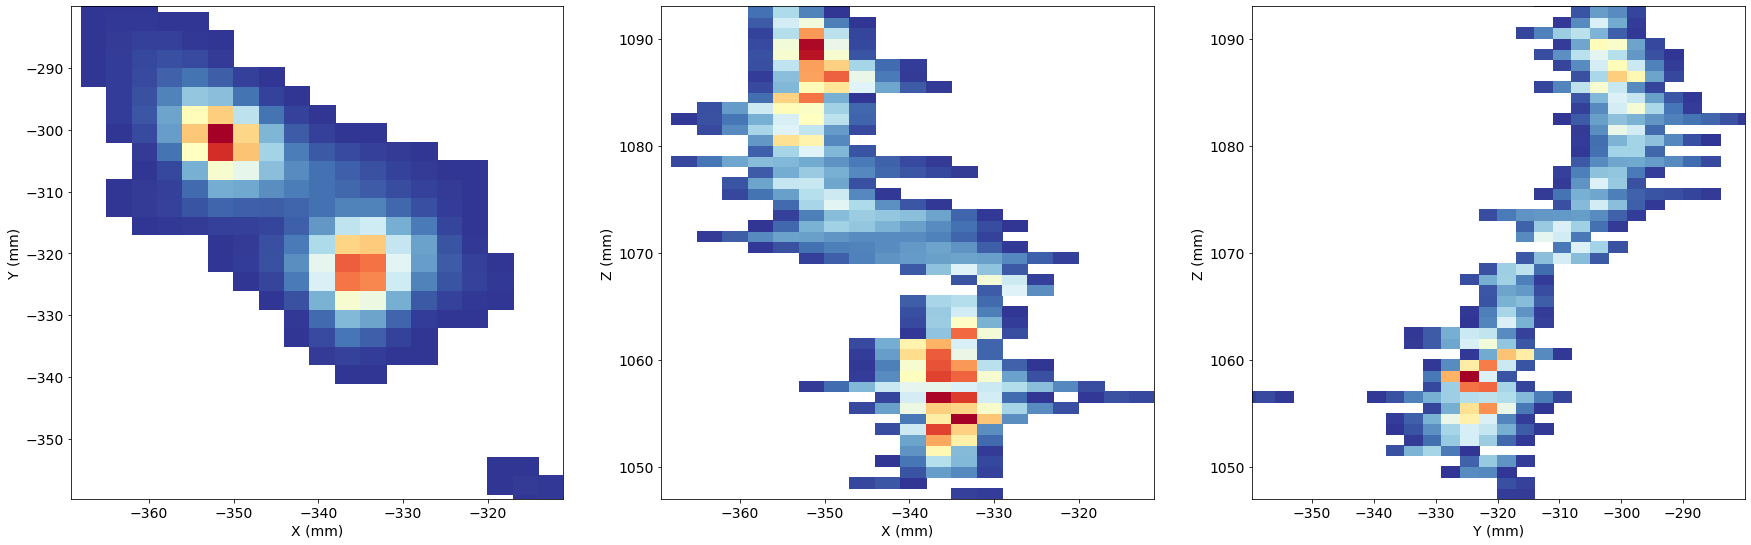

In [654]:
binHits = bin_hits(dcHits, pitch = (3,3))
plot_hits_projections(dcHits2, binHits,  masked=True, figsize=(30, 10))

In [655]:
dcHits

<EventHits>
        event number = 215
        event type   = None
        topology     = None
        Columns = ('x', 'y', 'z', 'energy')
        

## Make tracks from deconvolved hits

In [656]:
bin_size=5
contiguity=20
voxHits = voxelize_hits(dcHits, bin_size)


In [657]:
voxHits

<VoxelHits>
        event number = 215
        voxel bin    = 5
        barycenter   = True
        xyz_bins     = 0.002431
        Columns      = ('x', 'y', 'z', 'energy', 'nhits')
        

In [658]:
voxHits.df

,x,y,z,energy,nhits
0,-366.250000,-295.049988,1078.000000,0.150425,1.0
1,-366.250000,-296.249833,1081.616475,0.343693,3.0
2,-366.250000,-292.049988,1078.000000,0.432616,1.0
3,-366.250000,-287.759605,1078.000000,1.236377,2.0
4,-366.250000,-286.049988,1082.000000,0.162439,1.0
...,...,...,...,...,...
283,-320.700012,-311.788216,1069.000000,0.827936,2.0
284,-320.700012,-307.600006,1069.000000,0.285394,1.0
285,-312.959593,-356.700012,1056.000000,2.331656,2.0
286,-313.440332,-353.700012,1056.000000,0.526014,2.0


In [659]:
start_time = time.perf_counter() 
gtracks  = make_track_graphs(voxHits, contiguity)
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f' make track-graphs in {run_time} seconds')
print(f" event in list {evt}, event id = {voxHits.event_id} nof gtracks = {len(gtracks)}")

 make track-graphs in 0.5009474929829594 seconds
 event in list 3, event id = 215 nof gtracks = 2


In [660]:
start_time = time.perf_counter() 
GTRKS = [GTrack(gtr, voxHits.event_id, voxel_bin=bin_size, contiguity=10)\
                             for gtr in gtracks]
end_time   = time.perf_counter()      # 2
run_time   = end_time - start_time 
print(f'GTrks in {run_time} seconds')

GTrks in 6.868525028985459 seconds


In [661]:
from tics.graphics_reco import plot_gtrack

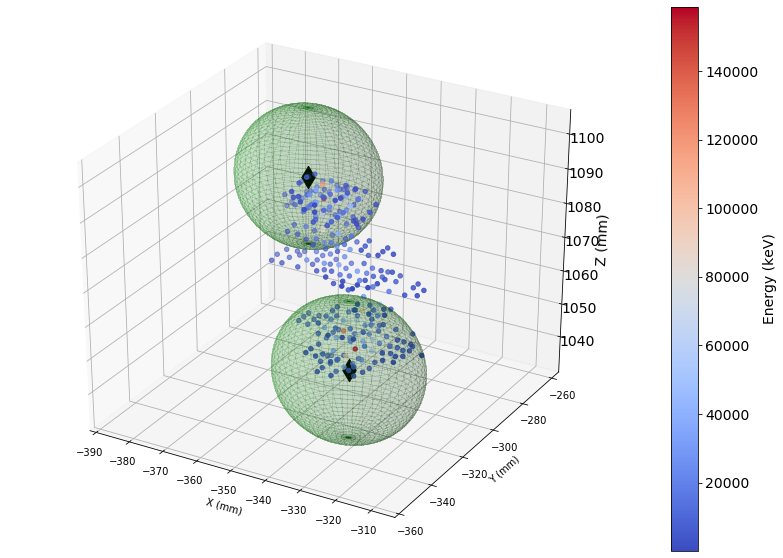

In [662]:
plot_gtrack(GTRKS[0], rb=20)

In [663]:
GTRKS[1].voxels_df

,x,y,z,energy,nhits
0,-317.149994,-353.700012,1056.0,0.220908,1.0
1,-317.149994,-356.700012,1056.0,0.303369,1.0
2,-313.440332,-353.700012,1056.0,0.526014,2.0
3,-312.959593,-356.700012,1056.0,2.331656,2.0
